## AI Final Project Requirements:
## Analyze a digital event:
1. Define the event in class
2. Definition of the problem and comments of the script (i.e. one per line) (10%)
3. Scrap the data (10%)
4. Clean the dataset (10%)
5. Topic analysis (10%)
6. Identify several types of users using different features (20%)
7. Propose a model for a selected variable that is easy to explain to a decision-maker (20%)
8. Propose a model for the same selected variable that is as accurate as possible (20%)

## About the project

This project is mainly divided it into 3 parts:

1. Scrap tweets about the movie Justice League and the users' information. Clean the texts of tweets and do topic analysis with PCA.
2. Based users' information we get from part 1, we clean the data and use KMeans to classify users.
3. We find a dataset about movies' information on Kaggle. The data is from The Movie Database. We clean the data in this dataset and build machine learning models (Decision Tree, Random Forest, GradientBoostClassifier) to predict if a movie's revenue can be larger than its budget. That is, if the movie can make profit. 


In [1]:
# import necessary libraries, more libraries may also be imported later as used
import json
import pymongo
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


### 1. Scrap the data

In [2]:
# API Authentication

with open('consumer_key.txt', 'r') as f:
    consumer_key =  f.read()
f.closed

with open('consumer_secret.txt', 'r') as f:
    consumer_secret = f.read()
f.closed

with open('access_key.txt', 'r') as f:
    access_key = f.read()
f.closed

with open('access_secret.txt', 'r') as f:
     access_secret = f.read()
f.closed

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [3]:
from tweepy import Stream,StreamListener
import time

class listener(StreamListener):
    # initiate listener
    def __init__(self):
        super(StreamListener, self).__init__()
        self.num_tweets = 0
        # connect with MongoDB
        try:
            #use your database name, user and password here:
            #mongodb://<dbuser>:<dbpassword>@<mlab_url>/<database_name>
            with open("credentials.txt", 'r', encoding='utf-8') as f:
                [name,password,url,dbname]=f.read().splitlines()
                self.conn=pymongo.MongoClient("mongodb://{}:{}@{}/{}".format(name,password,url,dbname))
            print ("Connected successfully!!!")
        except pymongo.errors.ConnectionFailure as e:
            print ("Could not connect to MongoDB: %s" % e) 
        self.db = self.conn['cloudcomputing']
        self.collection = self.db['tweets']
    
    def on_data(self, status):
        
        if self.num_tweets < 5: # number of tweets we want
            
            jdata = json.loads(status)
            userinfo = api.get_user(id = jdata["user"]["id"])
            
            document={'user_id':jdata["user"]["id"], 'screen_name': jdata["user"]["screen_name"], 
                      'location': userinfo.location, 'description': userinfo.description, 
                      'number_of_follower':userinfo.followers_count, 'number_of_following': userinfo.friends_count,
                      'ratio':(userinfo.followers_count)/(userinfo.friends_count), 'text':jdata["text"]}
            self.collection.insert_one(document) 
            print(document)
            self.num_tweets += 1
            time.sleep(1)
            return True
        else:
            return False
    
    def on_error(self, status):
        print(status)


twitterStream = Stream(auth, listener())
twitterStream.filter(track = ['#JusticeLeague'])
# returns tweet contains "#JusticeLeague"
# sometimes it can be extremely slow
print ("done")

Connected successfully!!!
{'user_id': 811659649, 'screen_name': 'Sylphy_Bat', 'location': '', 'description': 'バットマンファン。基本コミック(原書)メイン。レビュー/考察等(ブログも更新中)。最近アサクリプレイ中(特にHaytham/Connor) バットマン創作小説等→ @Sylphy_Bruce', 'number_of_follower': 463, 'number_of_following': 141, 'ratio': 3.2836879432624113, 'text': "RT @BatmanNewsCom: Amazon has a listing for #JusticeLeague that's 15 minutes longer than the theatrical cut https://t.co/su2Ev85lnl", '_id': ObjectId('5a53ee5e40d21206f84c77ac')}
{'user_id': 263961264, 'screen_name': 'jedikat71', 'location': 'California, USA', 'description': 'Aspiring writer who loves movies & comic books. | Fangirl of Benedict Cumberbatch, Chris Evans, John Barrowman, Chris Pine, Jeremy Renner, & Gareth David-Lloyd.', 'number_of_follower': 1042, 'number_of_following': 1997, 'ratio': 0.5217826740110165, 'text': 'RT @FilmClickbait: 13 https://t.co/LHRmi37Bht', '_id': ObjectId('5a53eea740d21206f84c77ad')}
{'user_id': 109775943, 'screen_name': 'ystk_strtnr', 'location': '', 'd

### 2. Read data from MongoDB and clean data

In [4]:
# read content as a dataframe
tweets = pd.DataFrame(columns=['user_id','screen_name','location','description','number_of_follower','number_of_following','ratio','text'])

with open("credentials.txt", 'r', encoding='utf-8') as f:
    [name,password,url,dbname]=f.read().splitlines()
    conn = pymongo.MongoClient("mongodb://{}:{}@{}/{}".format(name,password,url,dbname))
db = conn['cloudcomputing']
collection = db['tweets']
i = 0
for doc in collection.find():
    tweets.loc[i] = [doc['user_id'], doc['screen_name'], doc['location'], doc['description'],
                    doc['number_of_follower'], doc['number_of_following'], doc['ratio'], doc['text']]
    i +=1

In [5]:
tweets.head()

,user_id,screen_name,location,description,number_of_follower,number_of_following,ratio,text
0,594770391,WhoistheFlair,,,23,43,0.534884,#JusticeLeague #Symbol of #HopeForThisYear ht...
1,18010232,MichaelSacal,"Mexico City, MX.",Chief Creative Officer https://t.co/aeVXKDKpYQ...,1687,2064,0.817345,RT @GreatKungLao: This thread is meant to expo...
2,18010232,MichaelSacal,"Mexico City, MX.",Chief Creative Officer https://t.co/aeVXKDKpYQ...,1687,2064,0.817345,RT @GreatKungLao: This thread is meant to expo...
3,2782502552,AndyGrail,,,92,98,0.938776,"Oh my god! Look at them PROTESTING. Screaming,..."
4,2782502552,AndyGrail,,,92,98,0.938776,"Oh my god! Look at them PROTESTING. Screaming,..."


In [6]:
tweets.drop_duplicates(inplace = True) # delete duplicate lines

In [7]:
# delete texts that are not written in English

# langtect is a python library that can detect the language of a string
# before import this library, please use "pip install langtect" in the terminal to install it 
from langdetect import detect
for text in tweets['text']:
    try:
        lang = detect(text)
        if lang != 'en':
            tweets.drop(tweets[tweets['text'] == text].index, inplace = True)
    except:
        tweets.drop(tweets[tweets['text'] == text].index, inplace = True)

In [8]:
texts_all = tweets["text"].drop_duplicates()# delete tweets with same content, e.g. retweet the same tweet
texts_all # all tweets that can be used, before preprocessing

0      #JusticeLeague #Symbol of #HopeForThisYear  ht...
1      RT @GreatKungLao: This thread is meant to expo...
3      Oh my god! Look at them PROTESTING. Screaming,...
6      RT @sttepodcast: Day nine of our twenty days o...
8      RT @itzmoe: Oh my gosh, look at this loud, cra...
11     RT @shayera_hal: I'm happy people also want Ke...
12     I can finally see why the visual effects of #J...
15     RT @Rfourone: #SuperSaturday \n#Trinity #Justi...
16     RT @thenerdstake: #hawkgirl #DCcomic #DCEU #Ju...
18     RT @LOTSloverCSS: We seriously need a #JLReuni...
19     @noobde Can We get one more chance For those w...
20     God vs God and then there's just #batman #supe...
22     The @MercedesBenz #ConceptCar in #JusticeLeagu...
23     Episode 48 - Marvel Did It Doggystyle\n#Podern...
24     RT @itzmoe: At least I know how #Superman felt...
25     RT @AndyGrail: Oh my god! Look at them PROTEST...
28     Anyone else is it incredibly ironic that the p...
29     RT @CBNostalgia: Unite t

In [9]:
# to clean tweets, we use the library Preprocessor (https://github.com/s/preprocessor)
# to install this library, please use "pip install tweet-preprocessor"
import preprocessor as p

texts_clean = []
for text in texts_all:
    text_clean = p.clean(text) # delete URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys
    texts_clean.append(text_clean)

In [10]:
texts_clean 

['of',
 ": This thread is meant to ee the lies by about . We didn't get…",
 'Oh my god! Look at them PROTESTING. Screaming, holding signs, throwing rocks and burning cars! DC fans are monsters…',
 ': Day nine of our twenty days of Funko is this Justice League Cyborg pop Just follow and RT this tweet to be i…',
 ': Oh my gosh, look at this loud, crazy protest! Yeah, lame YouTubers &amp; media reporting misinformation, we were just going take…',
 ": I'm happy people also want Kendra Saunders as the star of a new on-going title for Hawkgirl, as well many people want Shay…",
 'I can finally see why the visual effects of . The reshoots last summer of was quite rushed and d…',
 ':',
 ':',
 ': We seriously need a ! Bring back my and !',
 'Can We get one more chance For those who missed the opportunity to get the Gear in Injustice ?',
 "God vs God and then there's just …",
 'The in is awesome!',
 'Episode - Marvel Did It Doggystyle',
 ": At least I know how felt in . I'm just trying to do some

### 3. Topic Analysis

In [11]:
# Load package for seeing logs
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [12]:
import os
import tempfile
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

Folder "C:\Users\Ring\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


#### 3.1 From String to Vectors

In [13]:
import re
# remove common words and tokenize
stoplist = set('for a an is are of the and to in'.split())
words = [[word.lower() for word in re.split(r'[:;,.!?…"↪\s]\s*', text_clean) if word.lower() not in stoplist and word != ""]
         for text_clean in texts_clean]

In [14]:
words

[[],
 ['this',
  'thread',
  'meant',
  'ee',
  'lies',
  'by',
  'about',
  'we',
  "didn't",
  'get'],
 ['oh',
  'my',
  'god',
  'look',
  'at',
  'them',
  'protesting',
  'screaming',
  'holding',
  'signs',
  'throwing',
  'rocks',
  'burning',
  'cars',
  'dc',
  'fans',
  'monsters'],
 ['day',
  'nine',
  'our',
  'twenty',
  'days',
  'funko',
  'this',
  'justice',
  'league',
  'cyborg',
  'pop',
  'just',
  'follow',
  'rt',
  'this',
  'tweet',
  'be',
  'i'],
 ['oh',
  'my',
  'gosh',
  'look',
  'at',
  'this',
  'loud',
  'crazy',
  'protest',
  'yeah',
  'lame',
  'youtubers',
  '&amp',
  'media',
  'reporting',
  'misinformation',
  'we',
  'were',
  'just',
  'going',
  'take'],
 ["i'm",
  'happy',
  'people',
  'also',
  'want',
  'kendra',
  'saunders',
  'as',
  'star',
  'new',
  'on-going',
  'title',
  'hawkgirl',
  'as',
  'well',
  'many',
  'people',
  'want',
  'shay'],
 ['i',
  'can',
  'finally',
  'see',
  'why',
  'visual',
  'effects',
  'reshoots',
  

In [15]:
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for word in words:
    for token in word:
        frequency[token] += 1

words = [[token for token in word if frequency[token] > 1] for word in words]

from pprint import pprint  # pretty-printer
pprint(words)

[[],
 ['this', 'by', 'about', 'we', "didn't", 'get'],
 ['oh',
  'my',
  'god',
  'look',
  'at',
  'them',
  'protesting',
  'screaming',
  'holding',
  'signs',
  'throwing',
  'rocks',
  'burning',
  'cars',
  'dc',
  'fans',
  'monsters'],
 ['day',
  'our',
  'twenty',
  'days',
  'funko',
  'this',
  'justice',
  'league',
  'cyborg',
  'pop',
  'just',
  'follow',
  'rt',
  'this',
  'tweet',
  'be',
  'i'],
 ['oh',
  'my',
  'look',
  'at',
  'this',
  'yeah',
  '&amp',
  'we',
  'just',
  'going',
  'take'],
 ["i'm", 'people', 'also', 'want', 'as', 'new', 'as', 'well', 'people', 'want'],
 ['i', 'can', 'finally', 'see', 'why', 'effects', 'was', 'quite'],
 [],
 [],
 ['we', 'seriously', 'need', 'bring', 'my'],
 ['can', 'we', 'get', 'one', 'more', 'who', 'get'],
 ['god', 'vs', 'god', 'then', 'just'],
 ['awesome'],
 ['episode', '-', 'marvel', 'did', 'it', 'doggystyle'],
 ['at',
  'least',
  'i',
  'know',
  'how',
  "i'm",
  'just',
  'do',
  'something',
  'good',
  'people',
  'jus

In [16]:
# Load the package corpora from the library gensim
from gensim import corpora

D:\BigProgramFiles\Anaconda3\envs\py36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2018-01-08 23:27:09,972 : INFO : 'pattern' package not found; tag filters are not available for English


In [17]:
# Save the mapping between id and the words, known as dictionary
dictionary = corpora.Dictionary(words)
dictionary.save(os.path.join(TEMP_FOLDER, 'dataset.dict'))  # store the dictionary, for future reference
print(dictionary)

2018-01-08 23:27:11,424 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-08 23:27:11,431 : INFO : built Dictionary(377 unique tokens: ['this', 'by', 'about', 'we', "didn't"]...) from 240 documents (total 1503 corpus positions)
2018-01-08 23:27:11,433 : INFO : saving Dictionary object under C:\Users\Ring\AppData\Local\Temp\dataset.dict, separately None
2018-01-08 23:27:11,444 : INFO : saved C:\Users\Ring\AppData\Local\Temp\dataset.dict


Dictionary(377 unique tokens: ['this', 'by', 'about', 'we', "didn't"]...)


In [18]:
# Plot the number of tokens and occurances
print(dictionary.token2id)

{'this': 0, 'by': 1, 'about': 2, 'we': 3, "didn't": 4, 'get': 5, 'oh': 6, 'my': 7, 'god': 8, 'look': 9, 'at': 10, 'them': 11, 'protesting': 12, 'screaming': 13, 'holding': 14, 'signs': 15, 'throwing': 16, 'rocks': 17, 'burning': 18, 'cars': 19, 'dc': 20, 'fans': 21, 'monsters': 22, 'day': 23, 'our': 24, 'twenty': 25, 'days': 26, 'funko': 27, 'justice': 28, 'league': 29, 'cyborg': 30, 'pop': 31, 'just': 32, 'follow': 33, 'rt': 34, 'tweet': 35, 'be': 36, 'i': 37, 'yeah': 38, '&amp': 39, 'going': 40, 'take': 41, "i'm": 42, 'people': 43, 'also': 44, 'want': 45, 'as': 46, 'new': 47, 'well': 48, 'can': 49, 'finally': 50, 'see': 51, 'why': 52, 'effects': 53, 'was': 54, 'quite': 55, 'seriously': 56, 'need': 57, 'bring': 58, 'one': 59, 'more': 60, 'who': 61, 'vs': 62, 'then': 63, 'awesome': 64, 'episode': 65, '-': 66, 'marvel': 67, 'did': 68, 'it': 69, 'doggystyle': 70, 'least': 71, 'know': 72, 'how': 73, 'do': 74, 'something': 75, 'good': 76, 'anyone': 77, 'else': 78, 'incredibly': 79, 'ironic

In [19]:
# Let's convert the whole dataset into a corpus
corpus = [dictionary.doc2bow(word) for word in words]
# Save the data in case we need it later
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'dataset_corpus.mm'), corpus)
# Visualize it
for c in corpus:
    print(c)
# In the output: (0,1) means the tocken with index 0 shows up 1 time

2018-01-08 23:27:18,928 : INFO : storing corpus in Matrix Market format to C:\Users\Ring\AppData\Local\Temp\dataset_corpus.mm
2018-01-08 23:27:18,932 : INFO : saving sparse matrix to C:\Users\Ring\AppData\Local\Temp\dataset_corpus.mm
2018-01-08 23:27:18,933 : INFO : PROGRESS: saving document #0
2018-01-08 23:27:18,941 : INFO : saved 240x377 matrix, density=1.585% (1434/90480)
2018-01-08 23:27:18,957 : INFO : saving MmCorpus index to C:\Users\Ring\AppData\Local\Temp\dataset_corpus.mm.index


[]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]
[(0, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)]
[(0, 1), (3, 1), (6, 1), (7, 1), (9, 1), (10, 1), (32, 1), (38, 1), (39, 1), (40, 1), (41, 1)]
[(42, 1), (43, 2), (44, 1), (45, 2), (46, 2), (47, 1), (48, 1)]
[(37, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]
[]
[]
[(3, 1), (7, 1), (56, 1), (57, 1), (58, 1)]
[(3, 1), (5, 2), (49, 1), (59, 1), (60, 1), (61, 1)]
[(8, 2), (32, 1), (62, 1), (63, 1)]
[(64, 1)]
[(65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)]
[(10, 1), (32, 2), (37, 1), (42, 1), (43, 1), (69, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)]
[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18,

#### 3.2 TF-IDF

In [20]:
# Load the associated libraries
from gensim import corpora, models, similarities

In [21]:
# Transform the corpus into a bag of words counts that applies weighting to account for common terms
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2018-01-08 23:27:23,698 : INFO : collecting document frequencies
2018-01-08 23:27:23,701 : INFO : PROGRESS: processing document #0
2018-01-08 23:27:23,704 : INFO : calculating IDF weights for 240 documents and 376 features (1434 matrix non-zeros)


In [22]:
# If we assume that we have 12 features, then we can compact it by...
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12) # this function is for small data (<5000 documents)

2018-01-08 23:27:25,850 : INFO : creating sparse index
2018-01-08 23:27:25,852 : INFO : creating sparse matrix from corpus
2018-01-08 23:27:25,854 : INFO : PROGRESS: at document #0
2018-01-08 23:27:25,866 : INFO : created <240x12 sparse matrix of type '<class 'numpy.float32'>'
	with 1434 stored elements in Compressed Sparse Row format>


In [23]:
# we are interested in transforming the whole corpus
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

[]
[(0, 0.21139095821364123), (1, 0.3435987988839725), (2, 0.5491066164385001), (3, 0.3435987988839725), (4, 0.46960534030888706), (5, 0.4440116459433667)]
[(6, 0.22023414923284693), (7, 0.14736131858313178), (8, 0.24929522003217924), (9, 0.23292887369742737), (10, 0.18080073330491378), (11, 0.22023414923284693), (12, 0.2723622896253605), (13, 0.2723622896253605), (14, 0.23292887369742737), (15, 0.2723622896253605), (16, 0.2723622896253605), (17, 0.2723622896253605), (18, 0.2723622896253605), (19, 0.2723622896253605), (20, 0.20986180410424615), (21, 0.20109211125446583), (22, 0.2723622896253605)]
[(0, 0.24210622971956186), (23, 0.2689196817099712), (24, 0.24228842335838555), (25, 0.2878148602133189), (26, 0.2689196817099712), (27, 0.2878148602133189), (28, 0.17388493648076775), (29, 0.16657955171471436), (30, 0.3144461185649046), (31, 0.2878148602133189), (32, 0.20873700577131932), (33, 0.2878148602133189), (34, 0.24228842335838555), (35, 0.2878148602133189), (36, 0.20247696027998704),

#### 3.3 Latent Semantic indexing (LSI)

In [25]:
# We define two topics
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5) # build LSI modle
corpus_lsi = lsi[corpus_tfidf] # apply the model

2018-01-08 23:28:20,949 : INFO : using serial LSI version on this node
2018-01-08 23:28:20,952 : INFO : updating model with new documents
2018-01-08 23:28:20,959 : INFO : preparing a new chunk of documents
2018-01-08 23:28:20,963 : INFO : using 100 extra samples and 2 power iterations
2018-01-08 23:28:20,965 : INFO : 1st phase: constructing (377, 105) action matrix
2018-01-08 23:28:20,968 : INFO : orthonormalizing (377, 105) action matrix
2018-01-08 23:28:20,980 : INFO : 2nd phase: running dense svd on (105, 240) matrix
2018-01-08 23:28:20,988 : INFO : computing the final decomposition
2018-01-08 23:28:20,989 : INFO : keeping 5 factors (discarding 87.829% of energy spectrum)
2018-01-08 23:28:20,992 : INFO : processed documents up to #240
2018-01-08 23:28:20,994 : INFO : topic #0(2.496): -0.502*"this" + -0.257*"i" + -0.179*"cut" + -0.178*"we" + -0.171*"want" + -0.160*"you" + -0.149*"-" + -0.133*"it" + -0.133*"extended" + -0.132*"league"
2018-01-08 23:28:20,996 : INFO : topic #1(2.085): 

In [26]:
# We can see these two topics
lsi.print_topics()

2018-01-08 23:28:23,450 : INFO : topic #0(2.496): -0.502*"this" + -0.257*"i" + -0.179*"cut" + -0.178*"we" + -0.171*"want" + -0.160*"you" + -0.149*"-" + -0.133*"it" + -0.133*"extended" + -0.132*"league"
2018-01-08 23:28:23,452 : INFO : topic #1(2.085): -0.430*"this" + -0.366*"-" + 0.281*"wonder" + 0.240*"woman" + -0.214*"confirmation" + -0.213*"extended" + -0.204*"cut" + 0.163*"baymax" + 0.154*"with" + 0.135*"league"
2018-01-08 23:28:23,455 : INFO : topic #2(2.063): 0.600*"wonder" + 0.537*"woman" + 0.237*"this" + 0.120*"though" + 0.116*"vs" + 0.101*"rt" + -0.101*"it" + -0.100*"you" + 0.100*"baymax" + -0.098*"want"
2018-01-08 23:28:23,457 : INFO : topic #3(1.991): -0.416*"via" + -0.380*"out" + -0.350*"check" + -0.328*"lego" + -0.206*"gift" + -0.191*"toys" + -0.168*"super" + -0.161*"scooby" + -0.161*"doo" + -0.145*"this"
2018-01-08 23:28:23,458 : INFO : topic #4(1.935): 0.490*"-" + -0.263*"this" + 0.236*"cut" + 0.224*"baymax" + 0.212*"extended" + 0.210*"with" + 0.177*"confirmation" + 0.16

[(0,
  '-0.502*"this" + -0.257*"i" + -0.179*"cut" + -0.178*"we" + -0.171*"want" + -0.160*"you" + -0.149*"-" + -0.133*"it" + -0.133*"extended" + -0.132*"league"'),
 (1,
  '-0.430*"this" + -0.366*"-" + 0.281*"wonder" + 0.240*"woman" + -0.214*"confirmation" + -0.213*"extended" + -0.204*"cut" + 0.163*"baymax" + 0.154*"with" + 0.135*"league"'),
 (2,
  '0.600*"wonder" + 0.537*"woman" + 0.237*"this" + 0.120*"though" + 0.116*"vs" + 0.101*"rt" + -0.101*"it" + -0.100*"you" + 0.100*"baymax" + -0.098*"want"'),
 (3,
  '-0.416*"via" + -0.380*"out" + -0.350*"check" + -0.328*"lego" + -0.206*"gift" + -0.191*"toys" + -0.168*"super" + -0.161*"scooby" + -0.161*"doo" + -0.145*"this"'),
 (4,
  '0.490*"-" + -0.263*"this" + 0.236*"cut" + 0.224*"baymax" + 0.212*"extended" + 0.210*"with" + 0.177*"confirmation" + 0.168*"it\'s" + 0.162*"poster" + 0.143*"on"')]

In [27]:
# If we want to know how each document is related to each topic...
for doc in corpus_lsi:
    print(doc)

[]
[(0, -0.27268492862005617), (1, -0.072492211531308803), (2, 0.0091128632352471817), (3, -0.018288236128224208), (4, -0.077520645282055309)]
[(0, -0.10510530255232163), (1, 0.052040332492689259), (2, -0.071391049460593589), (3, -0.027059136995525392), (4, -0.028631206689180726)]
[(0, -0.38776720458232172), (1, -0.023880114295841491), (2, 0.22069021189324045), (3, -0.0078741905972098472), (4, -0.17690844191541025)]
[(0, -0.28375685629782721), (1, 0.00070438755798575884), (2, -0.038428446446300252), (3, 0.0016345162522618303), (4, -0.074575085662431734)]
[(0, -0.20795023757011913), (1, 0.14534191241783259), (2, -0.12713078435422265), (3, 0.050782050710025707), (4, 0.0044524739093212105)]
[(0, -0.17589206258166834), (1, 0.080847975300384345), (2, -0.090848359166800327), (3, 0.026351789690614004), (4, -0.076556664726041709)]
[]
[]
[(0, -0.13111449181524057), (1, 0.010258726521630004), (2, -0.038230993033815774), (3, 0.0007166321688578392), (4, -0.056121669533575134)]
[(0, -0.193972472263

In [ ]:
# Save the model..
#lsi.save('/tmp/model.lsi')
#lsi = models.LsiModel.load('/tmp/model.lsi')

#### 3.4 Try other methods

In [28]:
# Latent Dirichlet Allocation (LDA)
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5)

2018-01-08 23:28:30,994 : INFO : using symmetric alpha at 0.2
2018-01-08 23:28:30,997 : INFO : using symmetric eta at 0.002652519893899204
2018-01-08 23:28:30,998 : INFO : using serial LDA version on this node
2018-01-08 23:28:31,010 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 240 documents, updating model once every 240 documents, evaluating perplexity every 240 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-08 23:28:31,011 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-01-08 23:28:31,238 : INFO : -9.791 per-word bound, 886.1 perplexity estimate based on a held-out corpus of 240 documents with 504 words
2018-01-08 23:28:31,239 : INFO : PROGRESS: pass 0, at document #240/240
2018-01-08 23:28:31,391 : INFO : topic #0 (0.200): 0.016*"this" + 0.011*"with" + 0.010*"league" + 0.010*"hilarious" + 0.010*"wonder" + 0.010*"b

### 4. Classify Tweeter Users

In [29]:
tweets.head()

,user_id,screen_name,location,description,number_of_follower,number_of_following,ratio,text
0,594770391,WhoistheFlair,,,23,43,0.534884,#JusticeLeague #Symbol of #HopeForThisYear ht...
1,18010232,MichaelSacal,"Mexico City, MX.",Chief Creative Officer https://t.co/aeVXKDKpYQ...,1687,2064,0.817345,RT @GreatKungLao: This thread is meant to expo...
3,2782502552,AndyGrail,,,92,98,0.938776,"Oh my god! Look at them PROTESTING. Screaming,..."
6,806425307121123328,DuzahntheGamer,"Houston, USA","Ummmm, beer, video games, anime and gadgets . ...",56,127,0.440945,RT @sttepodcast: Day nine of our twenty days o...
8,2725347015,nexuspong,Hawaii,Just a nobody who likes to watch movies...,317,207,1.531401,"RT @itzmoe: Oh my gosh, look at this loud, cra..."


In [30]:
# As we can see, we don't have many meaningful features to classify users...
# we'd like to make use of location and description, not very complex, but whether or not a user publish his location and description could be a difference

tweets["hasLocation"] = [1 if tweets.loc[idx, "location"] != "" else 0 for idx in tweets.index]
tweets["hasDescription"] = [1 if tweets.loc[idx, "description"] != "" else 0 for idx in tweets.index]

In [31]:
tweets.head()

,user_id,screen_name,location,description,number_of_follower,number_of_following,ratio,text,hasLocation,hasDescription
0,594770391,WhoistheFlair,,,23,43,0.534884,#JusticeLeague #Symbol of #HopeForThisYear ht...,0,0
1,18010232,MichaelSacal,"Mexico City, MX.",Chief Creative Officer https://t.co/aeVXKDKpYQ...,1687,2064,0.817345,RT @GreatKungLao: This thread is meant to expo...,1,1
3,2782502552,AndyGrail,,,92,98,0.938776,"Oh my god! Look at them PROTESTING. Screaming,...",0,0
6,806425307121123328,DuzahntheGamer,"Houston, USA","Ummmm, beer, video games, anime and gadgets . ...",56,127,0.440945,RT @sttepodcast: Day nine of our twenty days o...,1,1
8,2725347015,nexuspong,Hawaii,Just a nobody who likes to watch movies...,317,207,1.531401,"RT @itzmoe: Oh my gosh, look at this loud, cra...",1,1


In [32]:
X = tweets[["ratio","number_of_following", "number_of_follower", "hasLocation", "hasDescription"]] # features to do clustering

In [33]:
# before clustering, we want to decide to make how many clusters 

# Fit clusters for various numbers of clusters
from sklearn.cluster import KMeans
K = range(1,10)
KM = [KMeans(n_clusters=k, random_state=0).fit(X) for k in K]
centroids = [km.cluster_centers_ for km in KM]   # cluster centroids

In [34]:
# Compute average euclidean distance between each point and its cluster centroid
from scipy.spatial.distance import cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

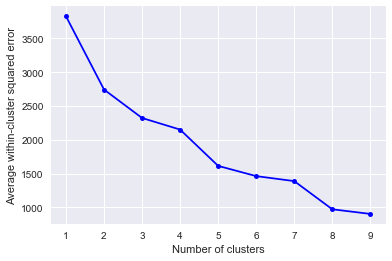

In [35]:
#Plot it
plt.plot()
plt.plot(K, avgWithinSS, 'b.-', ms=10)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster squared error')
plt.show()

In [36]:
# let's make 6 cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabaz_score

clustering = KMeans(n_clusters= 5).fit(X) # 
labels = clustering.labels_

#evaluate the model
# as the ground truth labels are not known, evaluation must be performed using the model itself.
print ("Silhouette score: ", silhouette_score(X, labels, metric='euclidean')) # the higher the better
print ("Calinski Harabaz score: ", calinski_harabaz_score(X, labels))  # the higher the better


Silhouette score:  0.818942553379
Calinski Harabaz score:  1382.08449963


### 5. A model to predict the performance of a movie
In this section, we are going to use several methods to predict the performance of a given movie. We use 2 targets seperately. First, whether this movie will make profits (marked as 1)or not (marked as 0). Then we predict its box office earnings.

#### 5.1 Load and clean data
We found some data about movies on Kaggle.com. The data is from The movie DataBase (TMDb). We are going to use this data frame to train our model. 

In [37]:
import json
#
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

df = load_tmdb_movies("tmdb_5000_movies.csv")

In [38]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [60]:
#df.head()

In [39]:
# clean dataset

movie_info = df[["title", "budget", "revenue", "genres", "original_language", "popularity", "runtime", "vote_average"]]
movie_info.head()

,title,budget,revenue,genres,original_language,popularity,runtime,vote_average
0,Avatar,237000000,2787965087,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,150.437577,162.0,7.2
1,Pirates of the Caribbean: At World's End,300000000,961000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,139.082615,169.0,6.9
2,Spectre,245000000,880674609,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,107.376788,148.0,6.3
3,The Dark Knight Rises,250000000,1084939099,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,112.312950,165.0,7.6
4,John Carter,260000000,284139100,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,43.926995,132.0,6.1


In [40]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
title                4803 non-null object
budget               4803 non-null int64
revenue              4803 non-null int64
genres               4803 non-null object
original_language    4803 non-null object
popularity           4803 non-null float64
runtime              4801 non-null float64
vote_average         4803 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 300.3+ KB


In [41]:
# fill NA in column runtime with the median of this column
movie_info.loc[movie_info["runtime"].isnull(), "runtime"] = movie_info["runtime"].median()

D:\BigProgramFiles\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
movie_info = movie_info.dropna() # drop rows with NA

In [63]:
# drop rows that doesn't contain any genres in genres column
movie_info2 = movie_info.copy()
for idx in range(len(movie_info)):
    if movie_info.iloc[idx, 3] == []:       
        movie_info2 = movie_info2.drop(movie_info.index[idx], axis=0)        # delete unuseful row with genres column Null


In [65]:
movie_info2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4802
Data columns (total 8 columns):
title                4775 non-null object
budget               4775 non-null int64
revenue              4775 non-null int64
genres               4775 non-null object
original_language    4775 non-null object
popularity           4775 non-null float64
runtime              4775 non-null float64
vote_average         4775 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 335.7+ KB


In [45]:
#movie_info.info()
movie_info2.describe()
# need to deal with outliers
# compared to "high" outliers, we think it's more important to deal with"low" outliers in this case
# because some movies can be very popular so that it has high revenue and popularity, but it's less likely so many movies have a 0 budget and revenue 

,budget,revenue,popularity,runtime,vote_average
count,4.775000e+03,4.775000e+03,4775.000000,4775.000000,4775.000000
mean,2.921458e+07,8.274265e+07,21.617344,107.205445,6.114199
std,4.078120e+07,1.632119e+08,31.867749,21.956185,1.140636
min,0.000000e+00,0.000000e+00,0.000372,0.000000,0.000000
25%,9.500000e+05,0.000000e+00,4.806600,94.000000,5.600000
50%,1.500000e+07,1.947206e+07,13.119133,104.000000,6.200000
75%,4.000000e+07,9.357130e+07,28.499077,118.000000,6.800000
max,3.800000e+08,2.787965e+09,875.581305,338.000000,10.000000


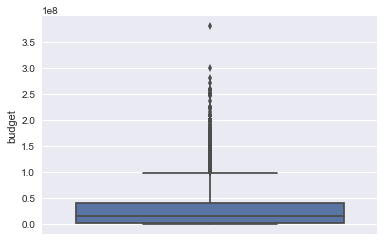

In [46]:
# deal with outliers
# budget outliers
sns.boxplot(y = movie_info2["budget"])

In [47]:
movie_info2["budget"].quantile(0.22)

20559.999999999945

In [48]:
movie_info2.loc[movie_info2["budget"]<movie_info2["budget"].quantile(0.22), 'budget'] = movie_info2["budget"].quantile(0.22)

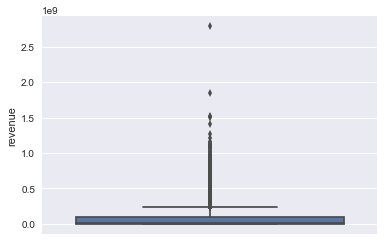

In [49]:
# revenue outliers
sns.boxplot(y = movie_info2["revenue"])

In [50]:
movie_info2["revenue"].quantile(0.30)

17473.4

In [51]:
# use the value of 30% quantitle of revenue to replace revenue value that is smaller than it
movie_info2.loc[movie_info2["revenue"]<movie_info2["revenue"].quantile(0.30), 'revenue'] = movie_info2["revenue"].quantile(0.30)

In [52]:
movie_info2.describe() # looks better now

,budget,revenue,popularity,runtime,vote_average
count,4.775000e+03,4.775000e+03,4775.000000,4775.000000,4775.000000
mean,2.921909e+07,8.274788e+07,21.617344,107.205445,6.114199
std,4.077797e+07,1.632093e+08,31.867749,21.956185,1.140636
min,2.056000e+04,1.747340e+04,0.000372,0.000000,0.000000
25%,9.500000e+05,1.747340e+04,4.806600,94.000000,5.600000
50%,1.500000e+07,1.947206e+07,13.119133,104.000000,6.200000
75%,4.000000e+07,9.357130e+07,28.499077,118.000000,6.800000
max,3.800000e+08,2.787965e+09,875.581305,338.000000,10.000000


In [53]:
# deal with column genres

# make a list of all genres, including duplications
genres = []
for genres_list in movie_info2["genres"]:
    for i in range(len(genres_list)):
        name = genres_list[i]["name"]
        genres.append(name)
#genres

In [54]:
# get unique genres and sort it 
genres_unique = list(set(genres))
genres_unique.sort()
genres_unique

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [55]:
genres_count = pd.DataFrame(genres_unique, columns=["type"]) # make a dataframe to count each genre's frequency

In [56]:
genres_count

,type
0,Action
1,Adventure
2,Animation
3,Comedy
4,Crime
5,Documentary
6,Drama
7,Family
8,Fantasy
9,Foreign


In [57]:
# get frequency of each genre
freqs = []
for genre in genres_unique:
    freq = genres.count(genre)
    freqs.append(freq)

# add column freqs to dataframe genres_count
genres_count["freqs"] = freqs
genres_count

,type,freqs
0,Action,1154
1,Adventure,790
2,Animation,234
3,Comedy,1722
4,Crime,696
5,Documentary,110
6,Drama,2297
7,Family,513
8,Fantasy,424
9,Foreign,34


In [58]:
genres_count.sort_values(by = ["freqs"], ascending= False).head() # sort the dataframe by frequency

,type,freqs
6,Drama,2297
3,Comedy,1722
17,Thriller,1274
0,Action,1154
14,Romance,894


In [67]:
# to tell if a movie's first genre is included in the top 5 popular movie genres
popular_genres = ["Drama", "Comedy", "Thriller", "Action", "Romance"] # top 5 popular movie genres that shows the most frequently in this database
IsPopularGenre = []

for idx in range(len(movie_info2)):
    genres_list = movie_info2.iloc[idx, 3]  # get the genres of this movie
    if genres_list[0]["name"] in popular_genres:
        IsPopularGenre.append(1) # if the movie's first genre in popular_genres, marked as 1
    else:
        IsPopularGenre.append(0)

In [68]:
movie_info2["IsPopularGenre"] = IsPopularGenre # add IsPopularGenre to movie_info2 as a column
movie_info2.head()

,title,budget,revenue,genres,original_language,popularity,runtime,vote_average,IsPopularGenre
0,Avatar,237000000,2787965087,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,150.437577,162.0,7.2,1
1,Pirates of the Caribbean: At World's End,300000000,961000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,139.082615,169.0,6.9,0
2,Spectre,245000000,880674609,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,107.376788,148.0,6.3,1
3,The Dark Knight Rises,250000000,1084939099,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,112.312950,165.0,7.6,1
4,John Carter,260000000,284139100,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,43.926995,132.0,6.1,1


In [69]:
movie_info2["original_language"].unique() # too many languages to create each language as a feature

# we devide it as Engligh-original movies (1) and non-Engligh_original movies (0)

array(['en', 'ja', 'fr', 'zh', 'es', 'de', 'hi', 'ru', 'ko', 'te', 'cn',
       'it', 'nl', 'ta', 'sv', 'th', 'da', 'xx', 'hu', 'cs', 'pt', 'is',
       'tr', 'nb', 'af', 'pl', 'he', 'ar', 'vi', 'ky', 'id', 'ro', 'fa',
       'no', 'sl', 'ps', 'el'], dtype=object)

In [70]:
movie_info2["IsEngOriginal"] = [1 if movie_info2.loc[idx, "original_language"] == "en" else 0 for idx in movie_info2.index ]

In [71]:
movie_info2.head()

,title,budget,revenue,genres,original_language,popularity,runtime,vote_average,IsPopularGenre,IsEngOriginal
0,Avatar,237000000,2787965087,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,150.437577,162.0,7.2,1,1
1,Pirates of the Caribbean: At World's End,300000000,961000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,139.082615,169.0,6.9,0,1
2,Spectre,245000000,880674609,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,107.376788,148.0,6.3,1,1
3,The Dark Knight Rises,250000000,1084939099,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,112.312950,165.0,7.6,1,1
4,John Carter,260000000,284139100,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,43.926995,132.0,6.1,1,1


In [72]:
# the final clean dataset for machine learning method

movie_features = movie_info2[["budget", "popularity", "runtime", "vote_average", "IsPopularGenre", "IsEngOriginal"]]
# target, 1 represents revenue > budget; 0 represents revenue < budget
movie_target = [1 if movie_info2.loc[idx, "revenue"] > movie_info2.loc[idx, "budget"] else 0 for idx in movie_info2.index ] 


#### 5.2 Apply machine learning method: one easy to understand method

In [74]:
%pylab inline
%run helper_functions.py

import sklearn
#sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


D:\BigProgramFiles\Anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [75]:
# A helper function to display the tree.
# NOTE: requires pydotplus and graphviz libraries. 
    
from IPython.display import Image 
import pydotplus
def plot_tree(clf, feature_names, target_names):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                             feature_names=feature_names,  
                             class_names= target_names,  
                             filled=True, rounded=True,  
                             special_characters=True) 
    return pydotplus.graph_from_dot_data(dot_data).create_png() 

Accuracy Training         : 0.794764397906
Accuracy Cross Validation : 0.65 (+/- 0.13)


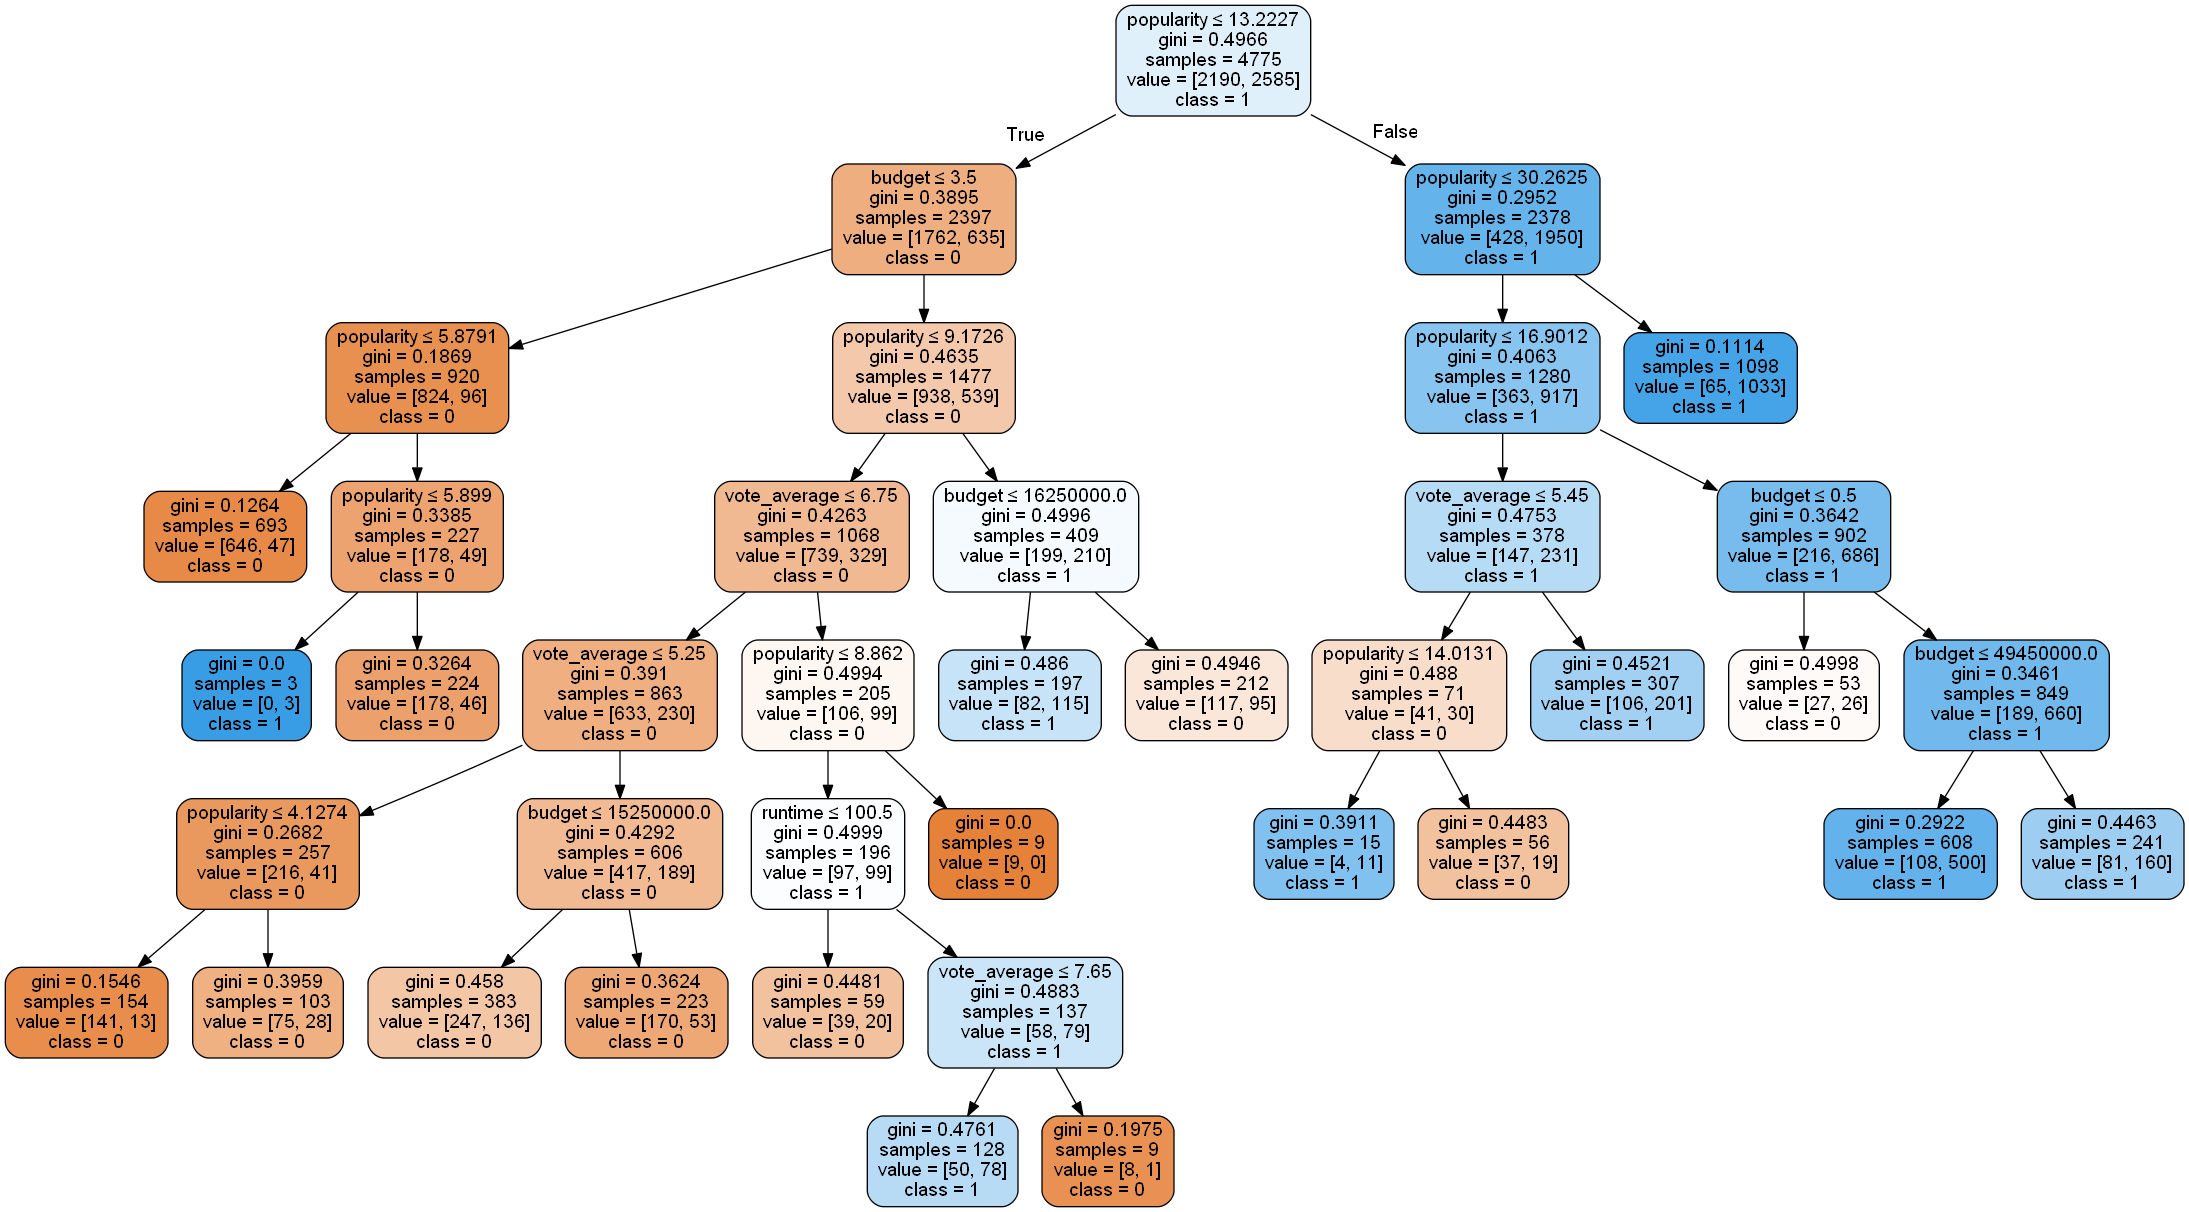

In [76]:
# to make it esay to understand and explain, we choose Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


tree = DecisionTreeClassifier(max_leaf_nodes=20, random_state=0) # A decision tree classifier
feature_names = movie_features.columns
target_names = ["0","1"]

# score at training
score_train = tree.fit(movie_features, movie_target).score(movie_features, movie_target) # training score
print("Accuracy Training         :", score_train)

scores = cross_val_score(tree, movie_features, movie_target, cv=10) # scores of cross validation
print("Accuracy Cross Validation : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# plot the tree
tree.fit(movie_features, movie_target)
Image(plot_tree(tree, feature_names, target_names))

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

params = { 
           'min_samples_leaf':  range(2,10),
           'max_leaf_nodes'  :  range(2,10)
         }

tree = DecisionTreeClassifier()

cv = ShuffleSplit(n_splits=10, random_state=0)
grid = GridSearchCV(estimator=tree, cv = cv, param_grid=params )
grid.fit(movie_features, movie_target)
# summarize the results of the grid search
print("Best parameters: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best parameters:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=5, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best score:  0.782217573222


#### 5.3 Another machine learning method: more accuracy
Besides Decision Tree, we also used Random Forest and GradientBoostingClassifier to do classification. From below we could see the accuracy are of the same level, after Grid Search.

In [78]:
# Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_leaf_nodes=4)
scores = cross_val_score(forest, movie_features, movie_target, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


important_features = pd.Series(data=forest.fit(movie_features, movie_target).feature_importances_ ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.75 (+/- 0.13)


popularity        0.735091
budget            0.179094
vote_average      0.043014
runtime           0.037889
IsEngOriginal     0.004912
IsPopularGenre    0.000000
dtype: float64

In [79]:
# Grid Search for Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

params = { 
           'min_samples_leaf':  range(2,10),
           'max_leaf_nodes'  :  range(2,10),
           'max_depth'       :  range(2, 5)
    
         }

forest = RandomForestClassifier()

cv = ShuffleSplit(n_splits=10, random_state=0)
grid = GridSearchCV(estimator=forest, cv = cv, param_grid=params)
grid.fit(movie_features, movie_target)
# summarize the results of the grid search
print("Best parameters: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best parameters:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=8,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best score:  0.781589958159


In [80]:
# GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier()
scores = cross_val_score(gboost, movie_features, movie_target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


important_features = pd.Series(data=gboost.fit(movie_features, movie_target).feature_importances_ ,index=feature_names)
important_features.sort_values(ascending=False)


Accuracy: 0.50 (+/- 0.13)


popularity        0.449434
budget            0.264776
runtime           0.144643
vote_average      0.122731
IsEngOriginal     0.012591
IsPopularGenre    0.005825
dtype: float64

In [81]:
# Grid Search for GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

params = { 
           'min_samples_leaf':  range(2,10),
           'max_leaf_nodes'  :  range(2,10)
         }

gboost = GradientBoostingClassifier()

cv = ShuffleSplit(n_splits=10, random_state=0)
grid = GridSearchCV(estimator=gboost, cv = cv, param_grid=params)
grid.fit(movie_features, movie_target)
# summarize the results of the grid search
print("Best parameters: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best parameters:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=3,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best score:  0.786820083682
